In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Imports and setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

Mounted at /content/drive


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths and dataset
data_dir = "/content/drive/MyDrive/dataset"

In [4]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:
# Load the full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
num_classes = len(full_dataset.classes)

# Split the dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.20 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Update validation and test datasets with test transforms
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

In [6]:
# Dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
# Model setup
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.3MB/s]


In [9]:
# Modify the final layer to match the number of classes in your dataset
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

# Unfreeze some layers for fine-tuning (optional)
for param in model.features.parameters():
    param.requires_grad = True

# Define the device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()

        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

# Train the model
epochs = 50
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)

Epoch 1/50
Train Loss: 2.9932, Train Acc: 0.0737
Val Loss: 2.8017, Val Acc: 0.0767
Epoch 2/50
Train Loss: 2.7989, Train Acc: 0.0666
Val Loss: 7.3236, Val Acc: 0.0487
Epoch 3/50
Train Loss: 2.9605, Train Acc: 0.0733
Val Loss: 2.9460, Val Acc: 0.0767
Epoch 4/50
Train Loss: 2.7985, Train Acc: 0.0737
Val Loss: 2.7839, Val Acc: 0.0885
Epoch 5/50
Train Loss: 2.8353, Train Acc: 0.0792
Val Loss: 2.7796, Val Acc: 0.0973
Epoch 6/50
Train Loss: 2.6756, Train Acc: 0.0973
Val Loss: 2.7253, Val Acc: 0.1254
Epoch 7/50
Train Loss: 2.5783, Train Acc: 0.1445
Val Loss: 2.5174, Val Acc: 0.1445
Epoch 8/50
Train Loss: 2.5170, Train Acc: 0.1589
Val Loss: 2.6187, Val Acc: 0.1593
Epoch 9/50
Train Loss: 2.4796, Train Acc: 0.1745
Val Loss: 2.4323, Val Acc: 0.1844
Epoch 10/50
Train Loss: 2.2524, Train Acc: 0.2448
Val Loss: 10.1548, Val Acc: 0.0988
Epoch 11/50
Train Loss: 3.1981, Train Acc: 0.1070
Val Loss: 2.9976, Val Acc: 0.0914
Epoch 12/50
Train Loss: 2.8104, Train Acc: 0.0834
Val Loss: 2.7416, Val Acc: 0.1121


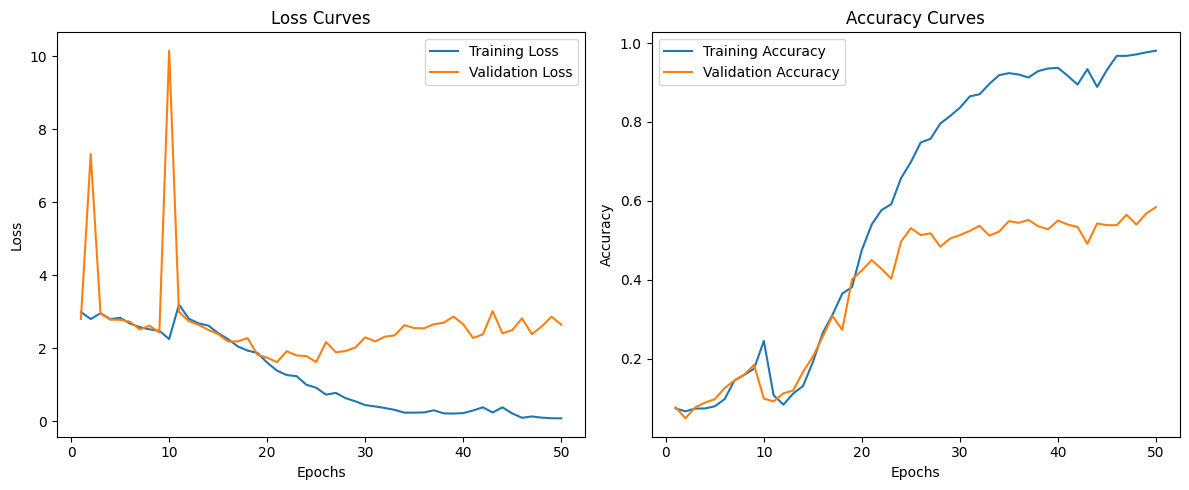

In [10]:
# Plot the accuracy and loss curves
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
                                precision    recall  f1-score   support

                   গোলাপ-Rose       0.70      0.50      0.58        14
   অপরাজিতা -Clitoria ternatea       0.95      0.88      0.91        24
     কচুরি ফুল-water hyacinths       0.59      0.57      0.58        35
          কদম - burflower tree       0.45      0.38      0.42        13
          কাঠগোলাপ-Frangipani       0.55      0.46      0.50        24
      কৃষ্ণচূড়া-Delonix regia       0.83      0.56      0.67         9
                 গাঁদা-Tagetes       0.67      0.42      0.52        19
      চন্দ্রপ্রভা-Tecoma stans       0.73      0.79      0.76        14
       জবা ফুল-Hibiscus Flower       0.52      0.44      0.48        27
ঢোল কলমি - Pink morning glory       0.59      0.59      0.59        29
  নয়নতারা-Catharanthus roseus       0.39      0.46      0.43        28
         পলাশ-Butea monosperma       0.73      0.92      0.81        12
    বুনো ডেইজি-Trailing Daisy       0.5

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2455 (\N{BENGALI LETTER GA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2503 (\N{BENGALI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2482 (\N{BENGALI LETTER LA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2474 (\N{BENGALI LETTER PA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/di

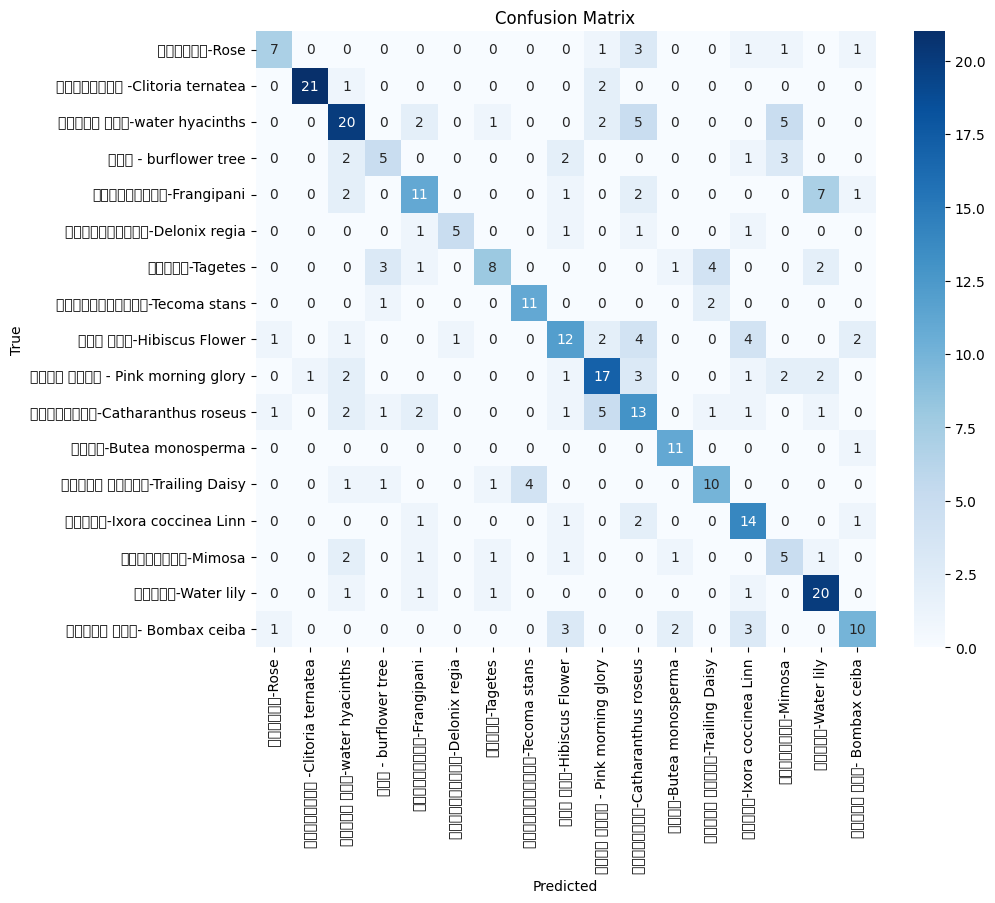

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Dataset path
dataset_path = '/content/drive/MyDrive/dataset'

# Load dataset
dataset = datasets.ImageFolder(dataset_path)

# Evaluate the model on the test dataset
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Get true and predicted labels
y_true, y_pred = evaluate_model(model, test_loader)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2455 (\N{BENGALI LETTER GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2503 (\N{BENGALI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  fig.can

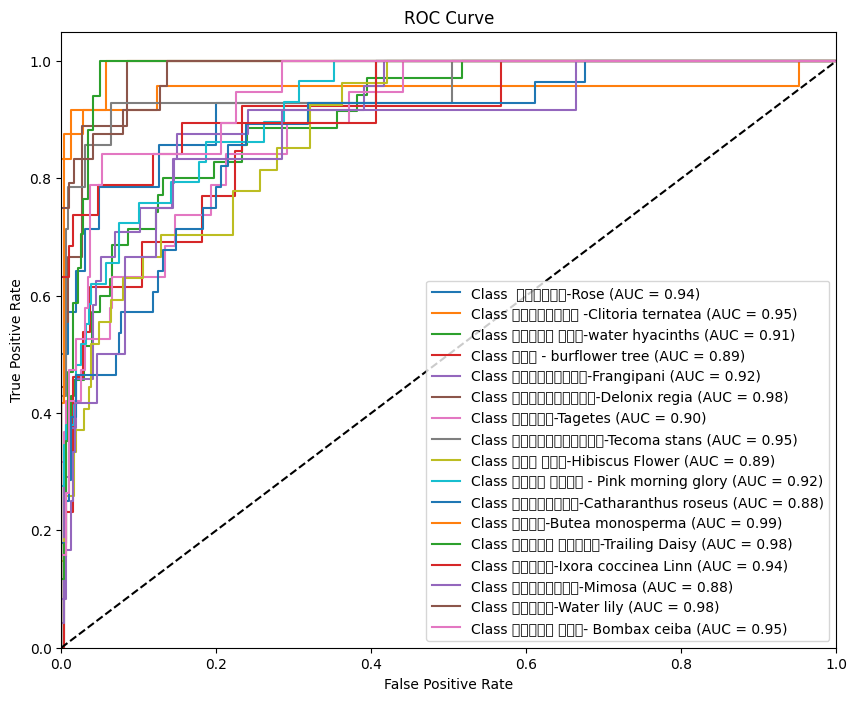

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the true labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=list(range(num_classes)))

# Get model predictions as probabilities
y_scores = []
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        y_scores.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

y_scores = np.array(y_scores)

# Plot the ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {dataset.classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [13]:
def calculate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

# Calculate accuracy on the test dataset
test_accuracy = calculate_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 59.00%
